In [1]:
import collections
import os
import sys
import time
import math

import cv2
import numpy as np
from IPython import display
from numpy.lib.stride_tricks import as_strided
from openvino.runtime import Core

from decoder import OpenPoseDecoder

sys.path.append("../utils")
import notebook_utils as utils

from playsound import playsound

color = (0, 255, 0)
font = cv2.FONT_HERSHEY_SIMPLEX

In [2]:
#color RGB values 
RED = (0,0,255)
BLUE = (128,0,0)
GREEN = (0,128,0)
PURPLE = (128,0,128)
YELLOW = (0,255,255)
MAGENTA = (255,0,255)
VIOLET = (255,20,147)

In [3]:
# A directory where the model will be downloaded.
base_model_dir = "model"

# The name of the model from Open Model Zoo.
model_name = "human-pose-estimation-0001"
# Selected precision (FP32, FP16, FP16-INT8).
precision = "FP16-INT8"

model_path = f"model/intel/{model_name}/{precision}/{model_name}.xml"
model_weights_path = f"model/intel/{model_name}/{precision}/{model_name}.bin"

if not os.path.exists(model_path):
    download_command = f"omz_downloader " \
                       f"--name {model_name} " \
                       f"--precision {precision} " \
                       f"--output_dir {base_model_dir}"
    ! $download_command

In [4]:
# Initialize OpenVINO Runtime
ie_core = Core()
# Read the network and corresponding weights from a file.
model = ie_core.read_model(model=model_path, weights=model_weights_path)
# Load the model on CPU (you can use GPU or MYRIAD as well).
compiled_model = ie_core.compile_model(model=model, device_name="GPU")

# Get the input and output names of nodes.
input_layer = compiled_model.input(0)
output_layers = list(compiled_model.outputs)

# Get the input size.
height, width = list(input_layer.shape)[2:]

In [5]:
input_layer.any_name, [o.any_name for o in output_layers]

('data', ['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

In [6]:
decoder = OpenPoseDecoder()

In [7]:
# 2D pooling in numpy (from: https://stackoverflow.com/a/54966908/1624463)
def pool2d(A, kernel_size, stride, padding, pool_mode="max"):
    """
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    """
    # Padding
    A = np.pad(A, padding, mode="constant")

    # Window view of A
    output_shape = (
        (A.shape[0] - kernel_size) // stride + 1,
        (A.shape[1] - kernel_size) // stride + 1,
    )
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(
        A,
        shape=output_shape + kernel_size,
        strides=(stride * A.strides[0], stride * A.strides[1]) + A.strides
    )
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling.
    if pool_mode == "max":
        return A_w.max(axis=(1, 2)).reshape(output_shape)
    elif pool_mode == "avg":
        return A_w.mean(axis=(1, 2)).reshape(output_shape)


# non maximum suppression
def heatmap_nms(heatmaps, pooled_heatmaps):
    return heatmaps * (heatmaps == pooled_heatmaps)


# Get poses from results.
def process_results(img, pafs, heatmaps):
    # This processing comes from
    # https://github.com/openvinotoolkit/open_model_zoo/blob/master/demos/common/python/models/open_pose.py
    pooled_heatmaps = np.array(
        [[pool2d(h, kernel_size=3, stride=1, padding=1, pool_mode="max") for h in heatmaps[0]]]
    )
    nms_heatmaps = heatmap_nms(heatmaps, pooled_heatmaps)

    # Decode poses.
    poses, scores = decoder(heatmaps, nms_heatmaps, pafs)
    output_shape = list(compiled_model.output(index=0).partial_shape)
    output_scale = img.shape[1] / output_shape[3].get_length(), img.shape[0] / output_shape[2].get_length()
    # Multiply coordinates by a scaling factor.
    poses[:, :, :2] *= output_scale
    return poses, scores

In [8]:
chords = "Major"
chords_name = 'C Major'
chords_val = 0
sound_val = 0

In [9]:
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))


def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
    for pose in poses:
        points = pose[:, :2].astype(np.int32)
        points_scores = pose[:, 2]
        # Draw joints.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
        for i, j in skeleton:
            if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
                cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

In [10]:
colors = ((255, 0, 0), (255, 0, 255), (170, 0, 255), (255, 0, 85), (255, 0, 170), (85, 255, 0),
          (255, 170, 0), (0, 255, 0), (255, 255, 0), (0, 255, 85), (170, 255, 0), (0, 85, 255),
          (0, 255, 170), (0, 0, 255), (0, 255, 255), (85, 0, 255), (0, 170, 255))

default_skeleton = ((15, 13), (13, 11), (16, 14), (14, 12), (11, 12), (5, 11), (6, 12), (5, 6), (5, 7),
                    (6, 8), (7, 9), (8, 10), (1, 2), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6))

def draw_poses(img, poses, point_score_threshold, skeleton=default_skeleton):
    chords = "Major"
    chords_name = 'C Major'
    chords_val = 0
    sound_val = 0
    
    h, w, c = img.shape
    
    if poses.size == 0:
        return img

    img_limbs = np.copy(img)
#     for pose in poses:
#         points = pose[:, :2].astype(np.int32)
        
#         nose = points[0]
#         relbow = points[8]
#         rwrist = points[10]
#         lwrist = points[9]
#         lshoulder = points[5]
#         rshoulder = points[6]
        
# #         print(nose)
#         cv2.circle(img, tuple(nose), 10 , YELLOW, -1)
        
# #         print(relbow)
#         cv2.circle(img, tuple(relbow), 10 , YELLOW, -1)
        
# #         print(rwrist)
#         cv2.circle(img, tuple(rwrist), 10 , RED, -1)
        
# #         print(lwrist)
#         cv2.circle(img, tuple(lwrist), 10 , RED, -1)
        
# #         print(lshoulder)
#         cv2.circle(img, tuple(lshoulder), 10 , YELLOW, -1)
        
# #         print(rshoulder)
#         cv2.circle(img, tuple(rshoulder), 10 , YELLOW, -1)
        
#         sd = shoulder_dist = math.sqrt(((lshoulder[0] - rshoulder[0]) ** 2) + ((lshoulder[1] - rshoulder[1]) ** 2))
# #         print(shoulder_dist)

#         cv2.line(img, (int(lshoulder[0]), int(relbow[1])), (int(rshoulder[0] - 200), int(relbow[1])), MAGENTA, 5)
    
#         fret1 = int(lshoulder[0] + sd/4)
#         fret2 = int(lshoulder[0] + sd/7 + sd/4)
#         fret3 = int(lshoulder[0] + sd/7 + sd/7 + sd/4)
#         fret4 = int(lshoulder[0] + sd/7 + sd/7 + sd/7 + sd/4)
#         fret5 = int(lshoulder[0] + sd/7 + sd/7 + sd/7 + sd/7 + sd/4)
#         fret6 = int(lshoulder[0] + sd/7 + sd/7 + sd/7 + sd/7 + sd/7 + sd/4)
#         fret7 = int(lshoulder[0] + sd/7 + sd/7 + sd/7 + sd/7 + sd/7 + sd/7 + sd/4)
        
#         cv2.line(img, (fret1, int(lshoulder[1] - 50)), (fret1, int(lshoulder[1] + 200)), RED, 2)
#         cv2.line(img, (fret2, int(lshoulder[1] - 50)), (fret2, int(lshoulder[1] + 200)), RED, 2)
#         cv2.line(img, (fret3, int(lshoulder[1] - 50)), (fret3, int(lshoulder[1] + 200)), RED, 2)
#         cv2.line(img, (fret4, int(lshoulder[1] - 50)), (fret4, int(lshoulder[1] + 200)), RED, 2)
#         cv2.line(img, (fret5, int(lshoulder[1] - 50)), (fret5, int(lshoulder[1] + 200)), RED, 2)
#         cv2.line(img, (fret6, int(lshoulder[1] - 50)), (fret6, int(lshoulder[1] + 200)), RED, 2)
#         cv2.line(img, (fret7, int(lshoulder[1] - 50)), (fret7, int(lshoulder[1] + 200)), RED, 2)
        
#         if(rwrist[1] >= relbow[1]):
#             if(sound_val == 0):
#                 sound_val = 1
                    
#                 if(chords == "Major"):
#                     if(lwrist[0] <= fret1):
#                         chords_name = 'C Major'
# #                         playsound('C.mp3')
#                     if(lwrist[0] <= fret2 and lwrist[0] > fret1):
#                         chords_name = 'D Major'
# #                         playsound('D.mp3')
#                     if(lwrist[0] <= fret3 and lwrist[0] > fret2):
#                         chords_name = 'E Major'
# #                         playsound('E.mp3')
#                     if(lwrist[0] <= fret4 and lwrist[0] > fret3):
#                         chords_name = 'F Major'
# #                         playsound('F.mp3')
#                     if(lwrist[0] <= fret5 and lwrist[0] > fret4):
#                         chords_name = 'G Major'
# #                         playsound('G.mp3')
#                     if(lwrist[0] <= fret6 and lwrist[0] > fret5):
#                         chords_name = 'A Major'
# #                         playsound('A.mp3')
#                     if(lwrist[0] <= fret7 and lwrist[0] > fret6):
#                         chords_name = 'B Major'
# #                         playsound('B.mp3')
#                     if(lwrist[0] > fret7):
#                         chords_name = 'C Major'
# #                         playsound('C.mp3')
#                 if(chords == "Minor"):
#                     if(lwrist[0] <= fret1):
#                         chords_name = 'C Minor'
# #                         playsound('Cm.mp3')
#                     if(lwrist[0] <= fret2 and lwrist[0] > fret1):
#                         chords_name = 'D Minor'
# #                         playsound('Dm.mp3')
#                     if(lwrist[0] <= fret3 and lwrist[0] > fret2):
#                         chords_name = 'E Minor'
# #                         playsound('Em.mp3')
#                     if(lwrist[0] <= fret4 and lwrist[0] > fret3):
#                         chords_name = 'F Minor'
# #                         playsound('Fm.mp3')
#                     if(lwrist[0] <= fret5 and lwrist[0] > fret4):
#                         chords_name = 'G Minor'
# #                         playsound('Gm.mp3')
#                     if(lwrist[0] <= fret6 and lwrist[0] > fret5):
#                         chords_name = 'A Minor'
# #                         playsound('Am.mp3')
#                     if(lwrist[0] <= fret7 and lwrist[0] > fret6):
#                         chords_name = 'B Minor'
# #                         playsound('Bm.mp3')
#                     if(lwrist[0] > fret7):
#                         chords_name = 'C Minor'
# #                         playsound('Cm.mp3')
                    
#         if(rwrist[1] < relbow[1]):
#             sound_val = 0

#         if(lwrist[1] <= nose[1]):
#                 if(chords_val == 1):
#                     chords_val = 0
#         if(lwrist[1] > nose[1]):
#             chords_val = 1

#         if(chords_val == 0):
#             if(chords == "Minor"):
#                 chords = "Major"
#                 chords_val = 2
#             elif(chords == "Major"):
#                 chords = "Minor"
#                 chords_val = 2
                
#         cv2.putText(img, chords, (int(w-250),int(150)), font, 1.5, BLUE, 4, cv2.LINE_AA)
        
#         cv2.putText(img, chords_name, (int(w-250),int(80)), font, 1.5, BLUE, 4, cv2.LINE_AA)    
        
        points_scores = pose[:, 2]
        # Draw joints.
        for i, (p, v) in enumerate(zip(points, points_scores)):
            if v > point_score_threshold:
                cv2.circle(img, tuple(p), 1, colors[i], 2)
        # Draw limbs.
#         for i, j in skeleton:
#             if points_scores[i] > point_score_threshold and points_scores[j] > point_score_threshold:
#                 cv2.line(img_limbs, tuple(points[i]), tuple(points[j]), color=colors[j], thickness=4)
    cv2.addWeighted(img, 0.4, img_limbs, 0.6, 0, dst=img)
    return img

IndentationError: unexpected indent (<ipython-input-10-586e249ab305>, line 145)

In [11]:
# Main processing function to run pose estimation.
def run_pose_estimation(source=0, flip=False, use_popup=False, skip_first_frames=0):
    pafs_output_key = compiled_model.output("Mconv7_stage2_L1")
    heatmaps_output_key = compiled_model.output("Mconv7_stage2_L2")
    player = None
    
    chords = "Major"
    chords_name = 'C Major'
    chords_val = 0
    sound_val = 0
    
    try:
        # Create a video player to play with target fps.
        player = utils.VideoPlayer(source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()

        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
                
            h, w, c = frame.shape
#             print("H, W = ",h,w)

            # Resize the image and change dims to fit neural network input.
            # (see https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/human-pose-estimation-0001)
            input_img = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
            # Create a batch of images (size = 1).
            input_img = input_img.transpose((2,0,1))[np.newaxis, ...]

            # Measure processing time.
            start_time = time.time()
            # Get results.
            results = compiled_model([input_img])
            stop_time = time.time()

            pafs = results[pafs_output_key]
            heatmaps = results[heatmaps_output_key]
            # Get poses from network results.
            poses, scores = process_results(frame, pafs, heatmaps)
            
            # Draw poses on a frame.
            frame = draw_poses(frame, poses, 0.1)
            
            img = frame
            
            for pose in poses:
                points = pose[:, :2].astype(np.int32)

                nose = points[0]
                relbow = points[8]
                rwrist = points[10]
                lwrist = points[9]
                lshoulder = points[5]
                rshoulder = points[6]

        #         print(nose)
                cv2.circle(img, tuple(nose), 10 , YELLOW, -1)

        #         print(relbow)
                cv2.circle(img, tuple(relbow), 10 , YELLOW, -1)

        #         print(rwrist)
                cv2.circle(img, tuple(rwrist), 10 , RED, -1)

        #         print(lwrist)
                cv2.circle(img, tuple(lwrist), 10 , RED, -1)

        #         print(lshoulder)
                cv2.circle(img, tuple(lshoulder), 10 , YELLOW, -1)

        #         print(rshoulder)
                cv2.circle(img, tuple(rshoulder), 10 , YELLOW, -1)

                sd = shoulder_dist = math.sqrt(((lshoulder[0] - rshoulder[0]) ** 2) + ((lshoulder[1] - rshoulder[1]) ** 2))
        #         print(shoulder_dist)

                cv2.line(img, (int(lshoulder[0]), int(relbow[1])), (int(rshoulder[0] - 200), int(relbow[1])), MAGENTA, 5)
            
                fret1 = int(lshoulder[0] + sd/4)
                fret2 = int(lshoulder[0] + sd/5 + sd/4)
                fret3 = int(lshoulder[0] + sd/5 + sd/5 + sd/4)
                fret4 = int(lshoulder[0] + sd/5 + sd/5 + sd/5 + sd/4)
                fret5 = int(lshoulder[0] + sd/5 + sd/5 + sd/5 + sd/5 + sd/4)
                fret6 = int(lshoulder[0] + sd/5 + sd/5 + sd/5 + sd/5 + sd/5 + sd/4)
                fret7 = int(lshoulder[0] + sd/5 + sd/5 + sd/5 + sd/5 + sd/5 + sd/5 + sd/4)

                cv2.line(img, (fret1, int(lshoulder[1] - 50)), (fret1, int(lshoulder[1] + 200)), RED, 2)
                cv2.line(img, (fret2, int(lshoulder[1] - 50)), (fret2, int(lshoulder[1] + 200)), RED, 2)
                cv2.line(img, (fret3, int(lshoulder[1] - 50)), (fret3, int(lshoulder[1] + 200)), RED, 2)
                cv2.line(img, (fret4, int(lshoulder[1] - 50)), (fret4, int(lshoulder[1] + 200)), RED, 2)
                cv2.line(img, (fret5, int(lshoulder[1] - 50)), (fret5, int(lshoulder[1] + 200)), RED, 2)
                cv2.line(img, (fret6, int(lshoulder[1] - 50)), (fret6, int(lshoulder[1] + 200)), RED, 2)
                cv2.line(img, (fret7, int(lshoulder[1] - 50)), (fret7, int(lshoulder[1] + 200)), RED, 2)
                
                if(rwrist[1] >= relbow[1]):
                    if(sound_val == 0):
                        sound_val = 1

                        if(chords == "Major"):
                            if(lwrist[0] <= fret1):
                                chords_name = 'C Major'
                                playsound('C.mp3')
                            if(lwrist[0] <= fret2 and lwrist[0] > fret1):
                                chords_name = 'D Major'
                                playsound('D.mp3')
                            if(lwrist[0] <= fret3 and lwrist[0] > fret2):
                                chords_name = 'E Major'
                                playsound('E.mp3')
                            if(lwrist[0] <= fret4 and lwrist[0] > fret3):
                                chords_name = 'F Major'
                                playsound('F.mp3')
                            if(lwrist[0] <= fret5 and lwrist[0] > fret4):
                                chords_name = 'G Major'
                                playsound('G.mp3')
                            if(lwrist[0] <= fret6 and lwrist[0] > fret5):
                                chords_name = 'A Major'
                                playsound('A.mp3')
                            if(lwrist[0] <= fret7 and lwrist[0] > fret6):
                                chords_name = 'B Major'
                                playsound('B.mp3')
                            if(lwrist[0] > fret7):
                                chords_name = 'C Major'
                                playsound('C.mp3')
                        if(chords == "Minor"):
                            if(lwrist[0] <= fret1):
                                chords_name = 'C Minor'
                                playsound('Cm.mp3')
                            if(lwrist[0] <= fret2 and lwrist[0] > fret1):
                                chords_name = 'D Minor'
                                playsound('Dm.mp3')
                            if(lwrist[0] <= fret3 and lwrist[0] > fret2):
                                chords_name = 'E Minor'
                                playsound('Em.mp3')
                            if(lwrist[0] <= fret4 and lwrist[0] > fret3):
                                chords_name = 'F Minor'
                                playsound('Fm.mp3')
                            if(lwrist[0] <= fret5 and lwrist[0] > fret4):
                                chords_name = 'G Minor'
                                playsound('Gm.mp3')
                            if(lwrist[0] <= fret6 and lwrist[0] > fret5):
                                chords_name = 'A Minor'
                                playsound('Am.mp3')
                            if(lwrist[0] <= fret7 and lwrist[0] > fret6):
                                chords_name = 'B Minor'
                                playsound('Bm.mp3')
                            if(lwrist[0] > fret7):
                                chords_name = 'C Minor'
                                playsound('Cm.mp3')

                if(rwrist[1] < relbow[1]):
                    sound_val = 0

                if(lwrist[1] <= nose[1] and lwrist[1] > 0):
                    if(chords_val == 1):
                        chords_val = 0
                if(lwrist[1] > nose[1]):
                    chords_val = 1

                if(chords_val == 0):
                    if(chords == "Minor"):
                        chords = "Major"
                        chords_val = 2
                    elif(chords == "Major"):
                        chords = "Minor"
                        chords_val = 2

                cv2.putText(img, chords, (int(w-250),int(150)), font, 1.2, BLUE, 4, cv2.LINE_AA)

                cv2.putText(img, chords_name, (int(w-250),int(80)), font, 1.2, BLUE, 4, cv2.LINE_AA)    
        
            

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # mean processing time [ms]
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(frame, f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)", (20, 40),
                        cv2.FONT_HERSHEY_COMPLEX, f_width / 1000, (0, 0, 255), 1, cv2.LINE_AA)

            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

In [14]:
run_pose_estimation(source=1, flip=False, use_popup=True)

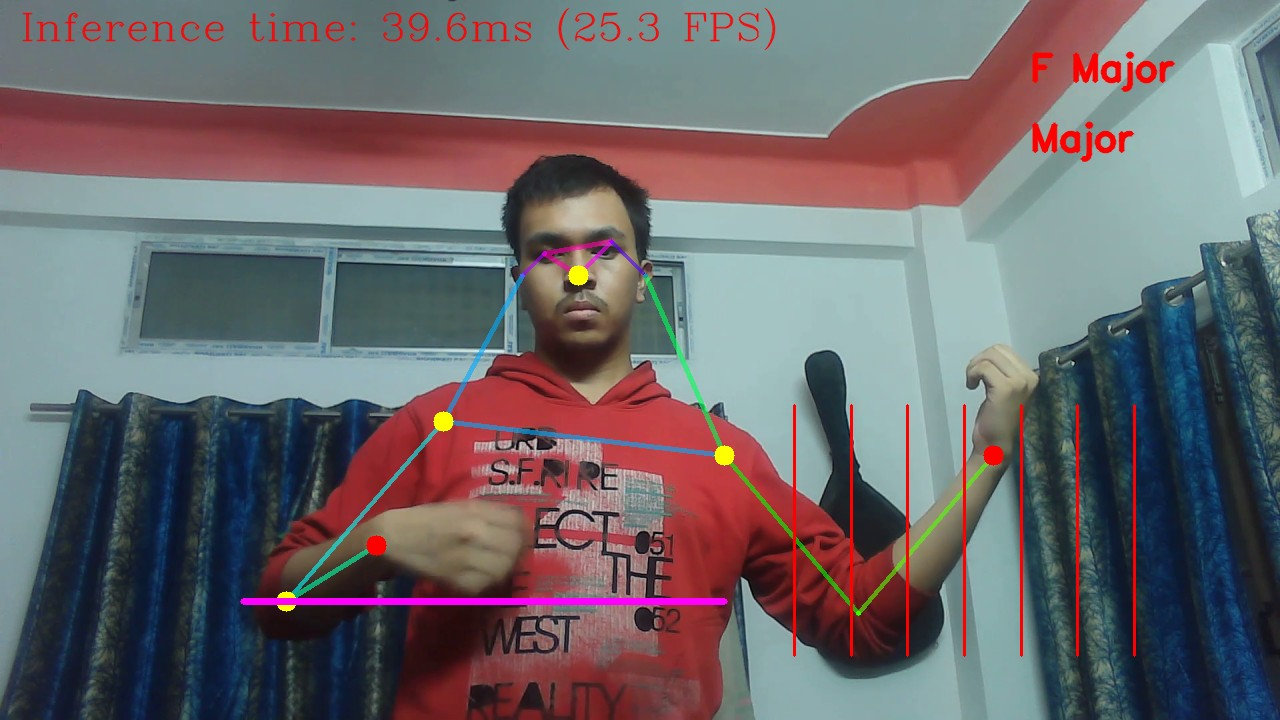

Interrupted


In [21]:
video_file = "video2.mp4"

run_pose_estimation(video_file, flip=False, use_popup=False, skip_first_frames=500)